In [1]:
import tensorflow as tf
import numpy as np
import os
import struct

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 数据准备

In [2]:
from sklearn.preprocessing import MinMaxScaler


def load_image(path):
    with open(path, 'rb') as fd:
        magic, num, rows, cols = struct.unpack('>IIII', fd.read(16))
        res = np.fromfile(fd, dtype=np.uint8).reshape(-1, 784)
    return res


def load_label(path):
    with open(path, 'rb') as fd:
        magic, n = struct.unpack('>II', fd.read(8))
        res = np.fromfile(fd, dtype=np.uint8)
    return res


class MnistData:
    def __init__(self, data_path, label_path, batch_size=32, normalize=False, shuffle=False):
        '''
        paths: 文件路径
        '''
        self._data = list()
        self._target = list()
        self._n_samples = 0
        self.n_features = 0

        self._idx = 0    # mini-batch的游标
        self._batch_size = batch_size

        self._load(data_path, label_path)

        if shuffle:
            self._shuffle_data()
        if normalize:
            self._normalize_data()

        print(self._data.shape, self._target.shape)

    def _load(self, data_path, label_path):
        '''
        载入数据
        '''
        self._data = load_image(data_path)
        self._target = load_label(label_path)

        self._n_samples, self.n_features = self._data.shape[0], self._data.shape[1]

    def _shuffle_data(self):
        '''
        打乱数据
        '''
        idxs = np.random.permutation(self._n_samples)
        self._data = self._data[idxs]
        self._target = self._target[idxs]

    def _normalize_data(self):
        scaler = MinMaxScaler()
        self._data = scaler.fit_transform(self._data)

    def next_batch(self):
        '''
        生成mini-batch
        '''
        while self._idx < self._n_samples:
            yield self._data[self._idx: (self._idx+self._batch_size)], self._target[self._idx: (self._idx+self._batch_size)]
            self._idx += self._batch_size

        self._idx = 0
        self._shuffle_data()

In [3]:
MNIST_DIR = '../dataset/MNIST/'
train_data_path = os.path.join(MNIST_DIR, 'train-images.idx3-ubyte')
train_label_path = os.path.join(MNIST_DIR, 'train-labels.idx1-ubyte')
test_data_path = os.path.join(MNIST_DIR, 't10k-images.idx3-ubyte')
test_label_path = os.path.join(MNIST_DIR, 't10k-labels.idx1-ubyte')

batch_size = 64
train_data = MnistData(train_data_path, train_label_path, batch_size=batch_size,
                       normalize=True, shuffle=True)
test_data = MnistData(test_data_path, test_label_path, batch_size=batch_size,
                      normalize=True, shuffle=False)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(60000, 784) (60000,)
(10000, 784) (10000,)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 网络结构设计

In [4]:
unit_I = train_data.n_features    # 输入单元数，等于特征数
unit_h = 512
unit_z = 2    # 设隐变量是2维的
unit_O = unit_I

# 搭建网络
注意，在这一节遇到一个坑，就是loss出现nan的问题。

当使用涉及到对数运算的损失时，一定要注意$log$的值一定要大于0，使用```tf.clip_by_value```来对值做一个截断处理；另一方面的原因来自于梯度爆炸，可以使用梯度截断技术来避免；还有的可能是因为学习率过大，调小学习率即可；还碰到过的情况是在使用relu函数时，因为relu存在单元坏死的问题，更换leakyrelu即可。

In [5]:
# 输入必须是可由用户指定的，所以设为placeholder
X = tf.placeholder(tf.float32, [None, unit_I])  # 数据的样本数不指定，只指定特征数

with tf.name_scope('VAE'):
    encoder = tf.layers.dense(X, unit_h,
                              activation=tf.nn.leaky_relu, name='encoder')

    z_mean = tf.layers.dense(encoder, unit_z, activation=None)
    z_std = tf.layers.dense(encoder, unit_z, activation=None)
    nos = tf.random_normal(tf.shape(z_mean))    # 标准高斯噪声
    z = z_mean+z_std*nos

    # 由隐变量z还原x
    decoder = tf.layers.dense(z, unit_h,
                              activation=tf.nn.leaky_relu, name='hidden')
    x_rec = tf.layers.dense(decoder, unit_O, 
                            name='decoder',activation=tf.nn.sigmoid)


# 生成图
Z = tf.placeholder(tf.float32, [None, unit_z])  # 数据的样本数不指定，只指定特征数
with tf.name_scope('Gen'):
    w_h = tf.get_default_graph().get_tensor_by_name('hidden/kernel:0')
    b_h = tf.get_default_graph().get_tensor_by_name('hidden/bias:0')
    w_decoder = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    b_decoder = tf.get_default_graph().get_tensor_by_name('decoder/bias:0')

    generater = tf.matmul(Z, w_h)+b_h
    generater = tf.nn.leaky_relu(generater)
    generater = tf.matmul(generater, w_decoder)+b_decoder
    generater = tf.nn.sigmoid(generater)

# 评估图
with tf.name_scope('Eval'):
    eps = 1e-8    # 极小值
    x_rec = tf.clip_by_value(x_rec, eps, 1-eps)    # 截断

    # 编码器损失，KL散度
    KL_loss = 0.5*(tf.square(z_mean)+tf.exp(z_std) -
                   tf.log(eps+tf.square(z_std))-1)
    KL_loss = tf.reduce_sum(KL_loss, axis=1)

    # 解码器损失
    rec_loss = X*tf.log(x_rec)+(1-X)*tf.log(1-x_rec)
    rec_loss = tf.reduce_sum(rec_loss, axis=1)    # 重构损失使用交叉熵

    ELBO = rec_loss-KL_loss    # 需要最大化的下界

    loss = tf.reduce_mean(-ELBO)    # 损失加负号

# 优化图
with tf.name_scope('train_op'):
    lr = 1e-3
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True    # 按需使用显存

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# 训练网络

In [6]:
with tf.Session(config=config) as sess:
    sess.run(init)
    epochs = 50

    batch_cnt = 0
    for epoch in range(epochs):
        for batch_data, batch_labels in train_data.next_batch():
            batch_cnt += 1
            loss_val, _ = sess.run(
                [loss, train_op],
                feed_dict={
                    X: batch_data,})

            # 每1000batch输出一次信息
            if (batch_cnt+1) % 1000 == 0:
                print('epoch: {}, batch_loss: {}' \
                      .format(epoch+1, loss_val))

            # 每5000batch做一次验证
            if (batch_cnt+1) % 5000 == 0:
                all_test_loss_val = list()
                for test_batch_data, test_batch_labels in test_data.next_batch():
                    test_loss_val = sess.run([loss],
                        feed_dict={X: test_batch_data})
                    all_test_loss_val.append(test_loss_val)
                test_loss = np.mean(all_test_loss_val)
                print('epoch: {}, test_loss: {}'.format(epoch+1, test_loss))
                
    # 生成不同范围的二维输入，生成图片
    n = 20
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)
    canvas = np.empty((28 * n, 28 * n))    # 画布，不同区域填充不同的图片

    
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]])
            x_mean = sess.run(generater,feed_dict={Z:z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j *
                   28:(j + 1) * 28] = x_mean[0].reshape(28, 28)

epoch: 2, batch_loss: 189.57102966308594
epoch: 3, batch_loss: 167.5538330078125
epoch: 4, batch_loss: 183.01365661621094
epoch: 5, batch_loss: 165.08013916015625
epoch: 6, batch_loss: 179.26158142089844
epoch: 6, test_acc: 172.16102600097656
epoch: 7, batch_loss: 163.30560302734375
epoch: 8, batch_loss: 170.513427734375
epoch: 9, batch_loss: 167.47329711914062
epoch: 10, batch_loss: 169.78863525390625
epoch: 11, batch_loss: 169.7701416015625
epoch: 11, test_acc: 172.701904296875
epoch: 12, batch_loss: 159.81707763671875
epoch: 13, batch_loss: 163.16293334960938
epoch: 14, batch_loss: 171.29733276367188
epoch: 15, batch_loss: 174.03884887695312
epoch: 16, batch_loss: 176.30519104003906
epoch: 16, test_acc: 168.56561279296875
epoch: 18, batch_loss: 175.69764709472656
epoch: 19, batch_loss: 176.39418029785156
epoch: 20, batch_loss: 172.79049682617188
epoch: 21, batch_loss: 155.66885375976562
epoch: 22, batch_loss: 166.5125274658203
epoch: 22, test_acc: 168.00595092773438
epoch: 23, batch

<Figure size 432x288 with 0 Axes>

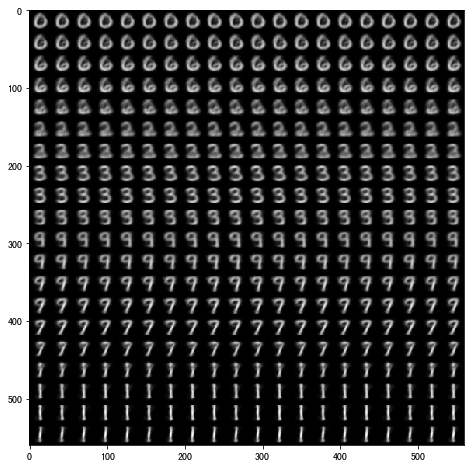

In [8]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(canvas, cmap='gray')
plt.show()